In [35]:
#  Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error


In [36]:
# water quality indices csv
df_indices = pd.read_csv("../../data/processed/indices_results.csv", index_col=0)

# Precipitation CSV
df_precip = pd.read_csv("../../data/processed/precip_monthly.csv", index_col=0)

# SST CSV (for reference, but will not be used)
#df_sst = pd.read_csv("../../data/processed/sst_monthly.csv", index_col=0)

In [39]:
# Convert time / index to datetime
df_indices.index = pd.to_datetime(df_indices.index, errors='coerce')
df_precip.index = pd.to_datetime(df_precip.index, errors='coerce')
df_sst.index    = pd.to_datetime(df_sst.index, errors='coerce')  

 # Sorting indices
df_indices = df_indices.sort_index()
df_precip = df_precip.sort_index()
df_sst    = df_sst.sort_index()  

In [40]:
# filtering to add  year/month column
df_indices_23_24 = df_indices.loc[df_indices.index.year.isin([2023, 2024])].copy()
df_indices_23_24['year']  = df_indices_23_24.index.year
df_indices_23_24['month'] = df_indices_23_24.index.month

df_precip_23_24 = df_precip.loc[df_precip.index.year.isin([2023, 2024])].copy()
df_precip_23_24['year']  = df_precip_23_24.index.year
df_precip_23_24['month'] = df_precip_23_24.index.month

In [42]:
# Merge variables to have year/month columns
df_corr = pd.merge(
    df_indices_23_24[['year','month','ndwi_mean','ndti_mean','ndci_mean']],
    df_precip_23_24[['year','month','precip']],
    on=['year','month'],
    how='inner'
)

df_corr = df_corr.rename(columns={
    'ndwi_mean':'NDWI',
    'ndti_mean':'NDTI',
    'ndci_mean':'NDCI',
    'precip':'Precipitation'
})

print(df_corr.head())

   year  month      NDWI      NDTI      NDCI  Precipitation
0  2023      1  0.214974 -0.139288  0.020004       0.978180
1  2023      1  0.213878 -0.146169  0.002451       0.978180
2  2023      2  0.326359 -0.224110  0.003297       1.713673
3  2023      2  0.124751 -0.109767  0.035807       1.713673
4  2023      3  0.330171 -0.209343 -0.001146       1.562143


## Pearson Correlation Among Water quality Indices

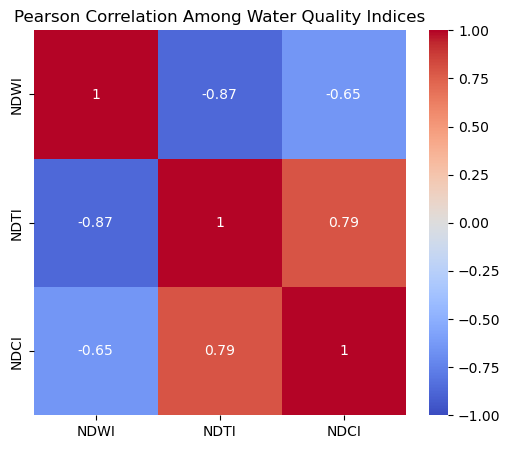

In [44]:
# Compute correlation among water quality indices
indices_corr = df_corr[['NDWI','NDTI','NDCI']].corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(indices_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Among Water Quality Indices')
plt.show()

## Paerson Correlation Matrix Between Water Quality Indices and Precipitation

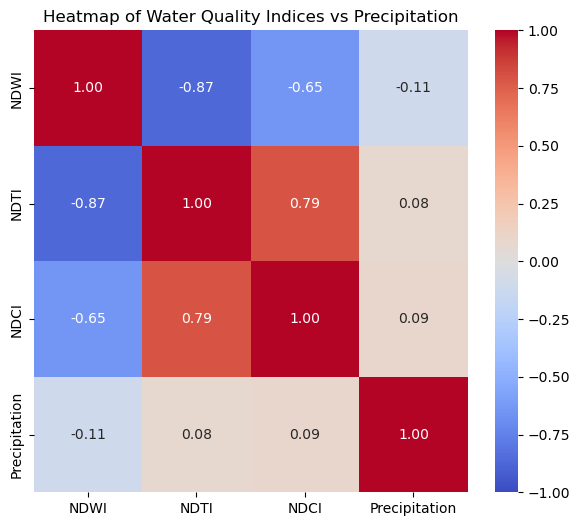

In [60]:
# Compute correlation matrix
corr_matrix = df_corr[['NDWI','NDTI','NDCI','Precipitation']].corr()

# Heatmap of correlations
plt.figure(figsize=(7,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Water Quality Indices vs Precipitation')
plt.show()

## RMSE Between Water Quality Indices and Precipitation

In [46]:
# Example: RMSE between NDWI and Precipitation
rmse_ndwi_precip = np.sqrt(mean_squared_error(df_corr['NDWI'], df_corr['Precipitation']))
rmse_ndti_precip = np.sqrt(mean_squared_error(df_corr['NDTI'], df_corr['Precipitation']))
rmse_ndci_precip = np.sqrt(mean_squared_error(df_corr['NDCI'], df_corr['Precipitation']))

print("RMSE NDWI vs Precipitation:", rmse_ndwi_precip)
print("RMSE NDTI vs Precipitation:", rmse_ndti_precip)
print("RMSE NDCI vs Precipitation:", rmse_ndci_precip)


RMSE NDWI vs Precipitation: 1.6488977286920365
RMSE NDTI vs Precipitation: 1.9732479815487585
RMSE NDCI vs Precipitation: 1.8185320375660525


## Plotting the RMSE values Among Variables

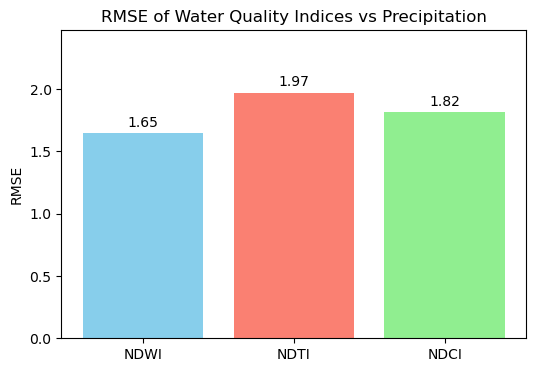

In [49]:
rmse_values = [1.6489, 1.9732, 1.8185]
indices = ['NDWI', 'NDTI', 'NDCI']

plt.figure(figsize=(6,4))
plt.bar(indices, rmse_values, color=['skyblue','salmon','lightgreen'])
plt.ylabel('RMSE')
plt.title('RMSE of Water Quality Indices vs Precipitation')
plt.ylim(0, max(rmse_values)+0.5)  # add some space on top
for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center', fontsize=10)
plt.show()


## Box Plots of Indices Relative to Environmental Variable

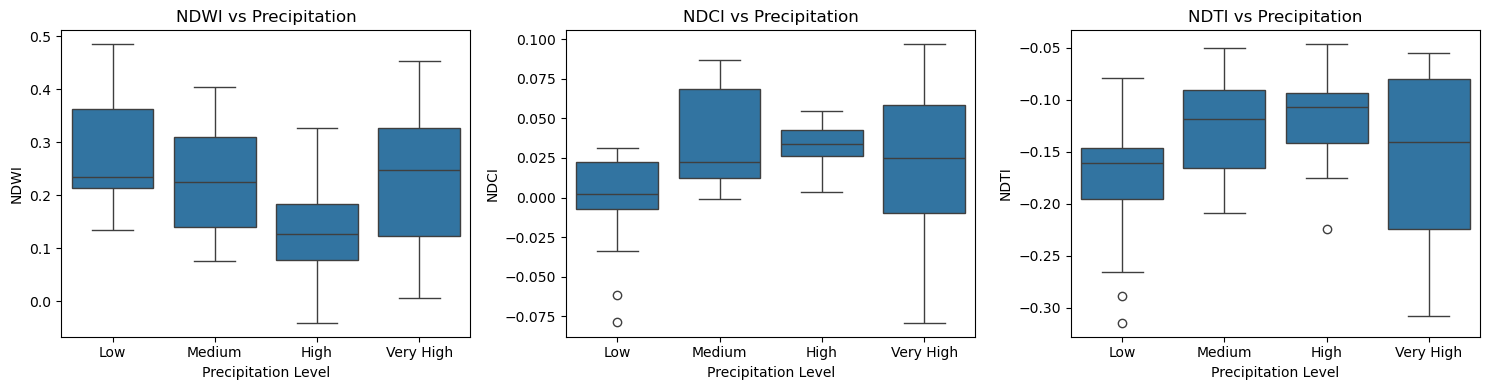

In [30]:
# Bin precipitation into quartiles
df_corr['precip_bin'] = pd.qcut(df_corr['Precipitation'], q=4, labels=['Low','Medium','High','Very High'])

# Plot boxplots for each index
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.boxplot(x='precip_bin', y='NDWI', data=df_corr)
plt.title('NDWI vs Precipitation')
plt.xlabel('Precipitation Level')

plt.subplot(1,3,2)
sns.boxplot(x='precip_bin', y='NDCI', data=df_corr)
plt.title('NDCI vs Precipitation')
plt.xlabel('Precipitation Level')

plt.subplot(1,3,3)
sns.boxplot(x='precip_bin', y='NDTI', data=df_corr)
plt.title('NDTI vs Precipitation')
plt.xlabel('Precipitation Level')

plt.tight_layout()
plt.show()

## Scatterplot Between Water Quality Indices and Precipitation

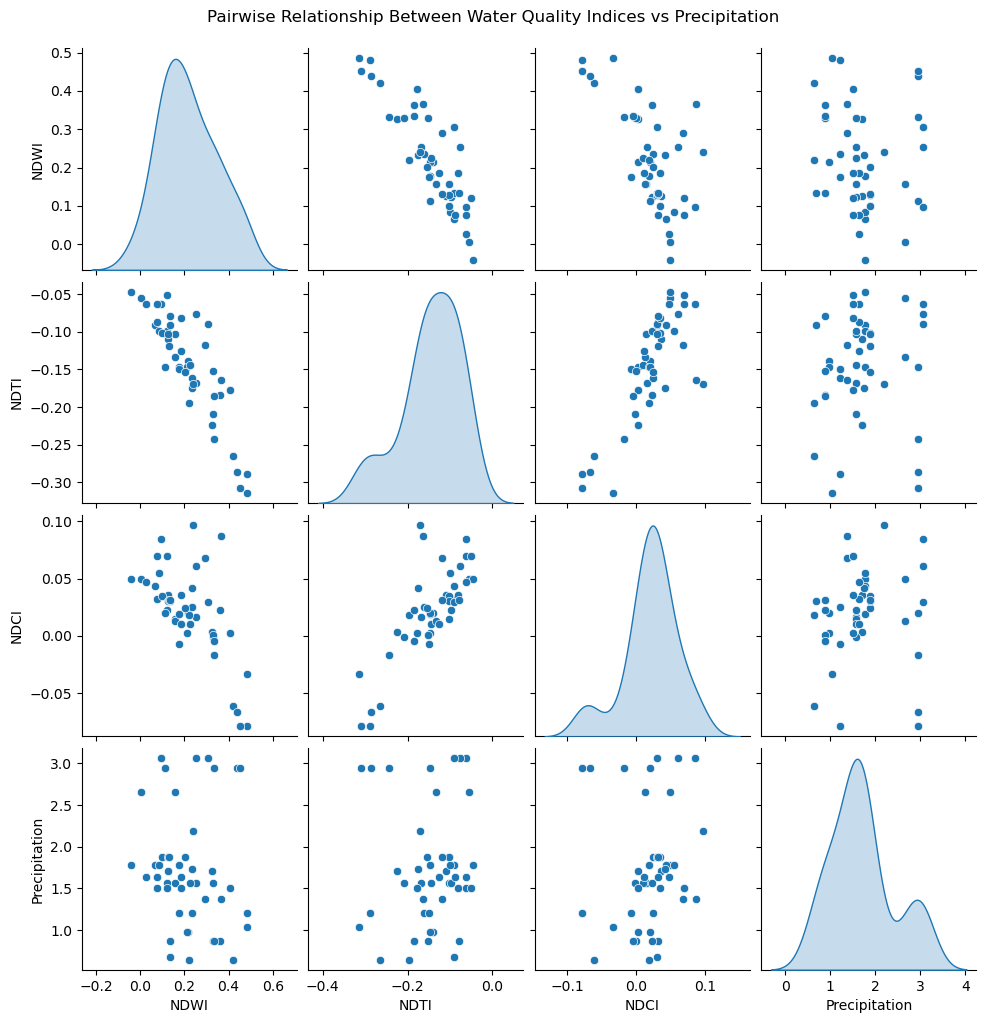

In [56]:
sns.pairplot(df_corr[['NDWI','NDTI','NDCI','Precipitation']], kind='scatter', diag_kind='kde')
plt.suptitle('Pairwise Relationship Between Water Quality Indices vs Precipitation', y=1.02)
plt.show()

## Principal Component Analysis (PCA)

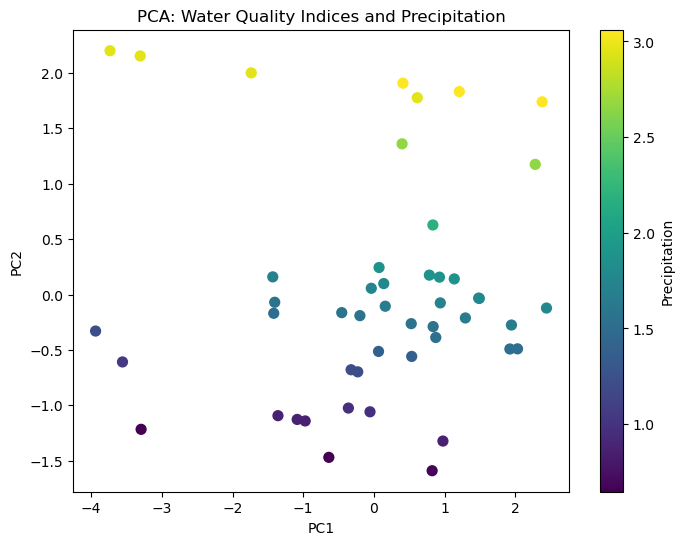

Explained variance ratio: [0.63862411 0.24634681]


In [20]:
features = ['NDWI','NDTI','NDCI','Precipitation']  # add 'SST' if available
x_scaled = StandardScaler().fit_transform(df_corr[features])

pca = PCA(n_components=2)
pc = pca.fit_transform(x_scaled)
df_pca = pd.DataFrame(pc, columns=['PC1','PC2'])

plt.figure(figsize=(8,6))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_corr['Precipitation'], cmap='viridis', s=50)
plt.colorbar(scatter, label='Precipitation')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: Water Quality Indices and Precipitation')
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

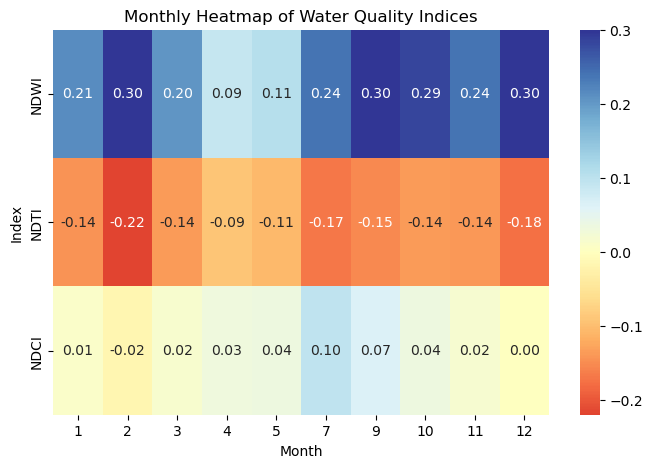

In [57]:
# Create monthly averages
heatmap_df = (
    df_corr
    .groupby('month')[['NDWI','NDTI','NDCI']]
    .mean()
)

plt.figure(figsize=(8,5))
sns.heatmap(
    heatmap_df.T,
    cmap='RdYlBu',
    center=0,
    annot=True,
    fmt=".2f"
)

plt.title('Monthly Heatmap of Water Quality Indices')
plt.xlabel('Month')
plt.ylabel('Index')
plt.show()